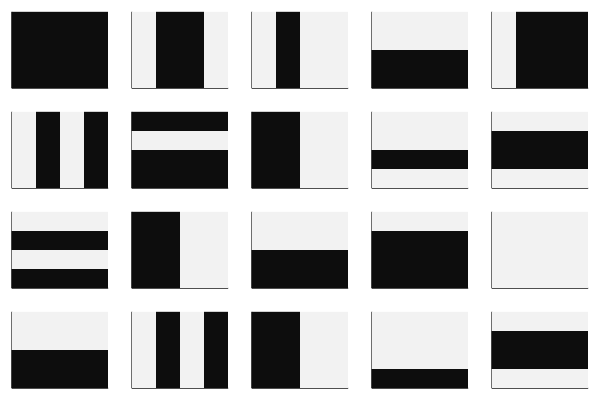

In [1]:
using Random
using Plots

n = 4
train = 20

function bars_and_stripes(train = 10) #Samples train data samples from the nxn bars_and_stripes synthetic dataset, WITH REPLACEMENT
    data = []
    for i in 1:train
        S = Int64[]
        while length(S) == 0 #Ensures length(S) is not 0 so we get truly uniform distribution over the whole bars and stripes dataset
            randsubseq!(S, collect(1:n), 0.5)
        end
        if 1 in S
            b = repeat(Bool[1], n)
        else
            b = repeat(Bool[0], n)
        end
        for i in 2:n
            temp = repeat(Bool[0], n)
            if i in S
                temp = repeat(Bool[1], n)
            end
            b = hcat(b, temp)
        end
        flip = rand() < 0.5
        if length(S) == n
            ret = flip ? b : .!b
        else
            ret = flip ? b : rotl90(b)
        end
        push!(data, ret)
    end
    return data
end

data_train = bars_and_stripes(train) #Stores data in data_train

plot([heatmap(x, color=:grays, colorbar = false, ticks = false) for x in data_train]...)

In [2]:
using Yao
using Flux

N = n^2 #Number of qubits

#Discriminator
d = Chain(Dense(N, 10, relu), Dense(10, 1, sigmoid))
nparams = sum(length, Flux.params(d))
println("Number of parameters in discriminator: $nparams")

#Generator
layers = 5
g = chain(N)
for _ in 1:layers
    for i in 1:N-1
        push!(g, rot(kron(N, i => X, i+1 => X), 0.))
    end
    for i in 1:N-1
        push!(g, rot(kron(N, i => X, i+1 => Y), 0.))
    end
    for i in 1:N
        push!(g, put(N, i => Rz(0.)))
    end
end

nparams = nparameters(g)
println("Number of parameters in generator: $nparams")  
dispatch!(g, rand(nparams).*2π);

Number of parameters in discriminator: 181


Number of parameters in generator: 230


[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

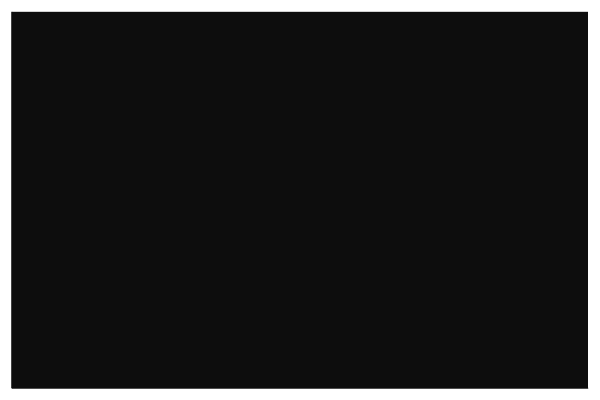

In [3]:
function pprior() #All 0s
    a = zeros(N)
    return FLOYao.product_state(Int.(a)) #Returns MajoranaReg; Prepares it to be sent through the generator 
end

pprior_example = zeros(N)
print(pprior_example)
heatmap(rotl90(reshape(pprior_example, n, n)) .> 0.5, color=:grays, colorbar = false, ticks = false)

In [4]:
using Flux: train!
using Yao
using FLOYao
using Statistics

function postprocess(g_output::Vector) #Turns the output of reg |> g |> measure into an Int vector
    result = []
    for i in 1:N 
        push!(result, g_output[1][end - i + 1])
    end
    Int.(result)
end

samplemean_batch = 100 #This doesn't need to be that big
dispatch!(g, rand(nparams).*2π)
function run_g(; theta = parameters(g), nbatch = samplemean_batch)
    dispatch!(g, theta)
    samples = []
    for i in 1:nbatch
        z = pprior() #MajoranaReg object
        result = z |> g |> measure |> postprocess
        if i == 1
            samples = result
        else
            samples = hcat(samples, result)
        end
    end
    samples
end
#outputs an N * #samples matrix

function run_d_fake(samples) #Runs discriminator on samples produced by generator
    if size(samples)[1] != N #Require samples to be an N x #samples matrix
        println("Improper formatting of samples")
        return
    end
    samples |> d
end

function run_d_real() #Runs d on all training data
    samples = []
    for i in 1:train
        result = data_train[i] |> vec
        if i == 1
            samples = result
        else
            samples = hcat(samples, result)
        end
    end
    samples |> d
end

function gLoss(; theta = parameters(g), nbatch = samplemean_batch) #Computes approximate loss function of generator via using sample mean, size of sample mean = samplemean_batch
    -mean(log.(run_d_fake(run_g(theta = theta, nbatch = nbatch))))
end

function dLoss(m, real, fake) #m is the discriminator, real is the actual data, fake is G(z) where z is sampled from pprior()
    -(log.(m(real)) + log.(1 .- m(fake))) |> first
end

dLoss (generic function with 1 method)

In [5]:
using Yao
using FLOYao

function parametershift_grad(theta = parameters(g)) #Shift parameters in-place
    l = nparameters(g)
    temp_params = theta
    temp_params[1] += π/2
    grad = zeros(l)
    for i in 1:l
        plus = 0
        minus = 0
        dispatch!(g, temp_params)
        plus = gLoss()
        temp_params[i] -= π
        dispatch!(g, temp_params)
        minus = gLoss()
        grad[i] = (plus - minus) / 2
        if i < l
            temp_params[i] += π/2
            temp_params[i+1] += π/2
        end
    end
    temp_params[l] += π/2
    dispatch!(g, temp_params)
    grad
end

parametershift_grad (generic function with 2 methods)

In [6]:
g_lr = 1e-3
d_lr = 1e-3

d_opt = Flux.setup(Adam(), d) 

gLoss_vals = []
dLoss_vals = []
mean_grads = []
dreal_vals = []
dfake_vals = []

g_epochs = 20
d_epochs = 1
epochs = 10
batch = train

for i in 1:epochs
    t = time()
    for j in 1:g_epochs
        ∇ = parametershift_grad()
        push!(mean_grads, mean(∇))
        dispatch!(-, g, ∇ * g_lr)
        push!(gLoss_vals, gLoss())
    end
    for j in 1:d_epochs
        real = []
        fake = []
        for m in 1:batch
            x = data_train[m] |> vec 
            push!(real, Int.(x))
            push!(fake, run_g(nbatch = 1))
        end
        data = collect(zip(real, fake)) 
        Flux.train!(dLoss, d, data, d_opt)
        s = 0
        for x in data
            s += dLoss(d, x[1], x[2])        
        end
        push!(dLoss_vals, s / batch)
    end
    d_fake = first(run_d_fake(run_g(nbatch = 1)))
    push!(dfake_vals, d_fake)
    index = rand(1:train)
    d_real = data_train[index] |> vec |> d |> first
    push!(dreal_vals, d_real)
    println("iteration $i done in: ", time() - t)
end

for _ in 1:g_epochs #Trains generator for g_epochs at the end 
    dispatch!(-, g, parametershift_grad() * g_lr)
    push!(gLoss_vals, gLoss())
end

In [ ]:
plot(gLoss_vals, title = "Generator Loss", linewidth=2)

In [ ]:
plot(dLoss_vals, title = "Discriminator Loss", linewidth=2)

In [ ]:
plot(mean_grads, title = "Mean of gradients", linewidth=2)

In [ ]:
#Testing the Discriminator

d_fake = first(run_d_fake(run_g(nbatch = 1)))
println("fake data: $d_fake") #Should print a number close to 0

index = rand(1:train)
d_real = data_train[index] |> vec |> d |> first
println("real data: $d_real") #Should print a number close to 1

In [ ]:
#Testing the Generator

nsamples = 25
samples = run_g(nbatch = nsamples)
plot([heatmap(reshape(samples[:, i], n, n), color=:grays, colorbar = false, ticks = false) for i in 1:nsamples]...)

In [ ]:
plot([heatmap(x, color=:grays, colorbar = false, ticks = false) for x in data_train]...)